<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.ub.edu/waveng">
      <img src="https://github.com/dmaluenda/resources/raw/master/ub_logo.png" width="130"/>
    </a>
  </td>
  <td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/WavefrontEngUB/VeReady/blob/main/DOE/HologramGenerator.ipynb">
      <img src="https://github.com/dmaluenda/resources/raw/master/colab_logo_32px.png" />
      Run in Google Colab
    </a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/WavefrontEngUB/VeReady/blob/main/DOE/HologramGenerator.ipynb">
      <img src="https://github.com/dmaluenda/resources/raw/master/github_logo_32px.png" />
      View source on GitHub
    </a>
  </td>
  <td>
    <a href="https://github.com/WavefrontEngUB/VeReady/raw/main/DOE/HologramGenerator.ipynb">
      <img src="https://github.com/dmaluenda/resources/raw/master/download_logo_32px.png" />
      Download notebook
    </a>
</table>

In [1]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import requests
from imageio import imwrite
from pathlib import Path

In [15]:
# This Notebook uses two modules from our group pubished on GitHub. Let's take them

# The first one is a pip-structurated package that can be just pip-installed, directly from GitHub.
for tries in range(2):
    try:
        import pyHolo
        from pyHolo.holo_generator import check_holo
        from pyHolo.holo_generator import get_holo_phase_only as get_holo
        from pyHolo.misc.report_utils import plot_entrance_beam_scalar as plot_field
    except ImportError:
        ans = input("Are you sure to install pyHolo? (Y/n)")
        if ans.lower().startswith(n):
            break
        !pip install https://github.com/WavefrontEngUB/pyHolo/archive/refs/heads/master.zip

# The second one is just a small file, also in GitHub.
zernikes_dir = Path('ZernikesBeam')
zernikes_file = zernikes_dir / 'cin_propaga.py'
if not (zernikes_dir.is_dir() and (zernikes_file).is_file()):
    zernikes_dir.mkdir(exist_ok=True)
    pyHolo.utils.download_from_github(zernikes_file, relative='DOE/ZernikesBeam',
                                      org='WavefrontEngUB', repo='VeReady',
                                      branch='main')

import ZernikesBeam.cin_propaga as ZernikeBeam

In [3]:
# Sistema Internacional Metric Units
m = 1
mm = 1e-3
um = 1e-6
nm = 1e-9

fig_num = 0  # Just to print Figure numbers

## DOE parameters

Fabrication limits (from mail): The DOE's sampling rate is `pixel_pitch`$=1\,\mu m$. They can print phase delays from $0$ to $2\pi$ liniarly with `phase_level`$=940$.

In [4]:
pixel_pitch = 1 * um
phase_levels = 940

phase_modulation = np.linspace(0, 2*np.pi, phase_levels)  # instrinsic phase-only modulation

map1 = []
map2 = []
accessible = []
for idx1, ph1 in enumerate(phase_modulation):
    for idx2, ph2 in enumerate(phase_modulation):
        if idx2<idx1:
            continue

        value = (np.exp(1j*ph1) + np.exp(1j*ph2))/2
        map1.append(idx1)
        map2.append(idx2)
        accessible.append(value)

slm_values = np.array(accessible)
map1_arr = np.array(map1)
map2_arr = np.array(map2)

print(f"Number of accessible values: {len(accessible)}")

Number of accessible values: 442270


In [5]:
def save_holo(label='holo'):
    print("Holo type is:", holo.dtype)  # check the type
    
    # let's save the hologram in a numpy file
    np.save(label, holo)

    imwrite(label+'.png', holo)

## Zernike's Beam

Let's get the coefficients from a file to set the Zernike's beam.

In [6]:
coeff = ZernikeBeam.load_coef(nterms=10)

### DOE of same size of MO diameter

The first attempt is to set the DOE's diameter equals to the Entrance Pupil of the Microscope Objective: `beam_diameter`$=4\,mm$

Efficiency =  0.2142229312566226


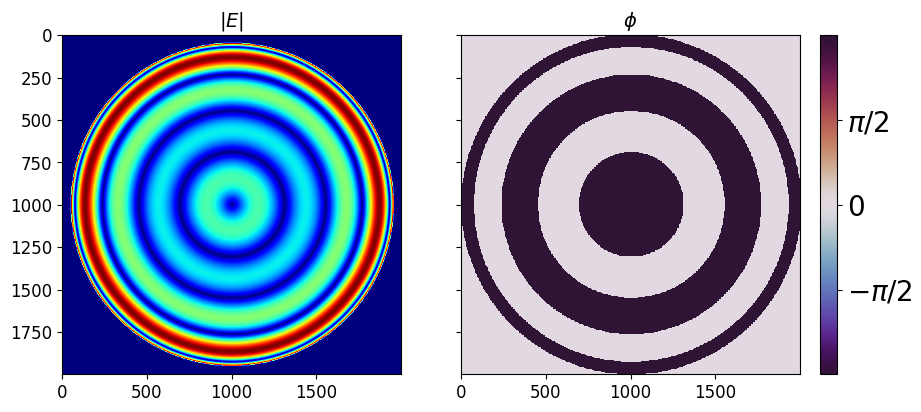

Figure 1: Zernike's beam (theoretical one)


<Figure size 640x480 with 0 Axes>

In [7]:
MO_diameter = 4 * mm

NP = int(MO_diameter/pixel_pitch) // 2  # It's half to consider Arrizon's procedure
rho = np.linspace(1e-10,1-1e-10, NP) # radial variable @ Gaussian sphere of reference

profile_EP = ZernikeBeam.get_EP(coeff, NP, rho)
fig_num = plot_field(profile_EP, title="Zernike's beam (theoretical one)", fig_num=fig_num)

Zernike's beam: 505 levels used out of 940 possible.


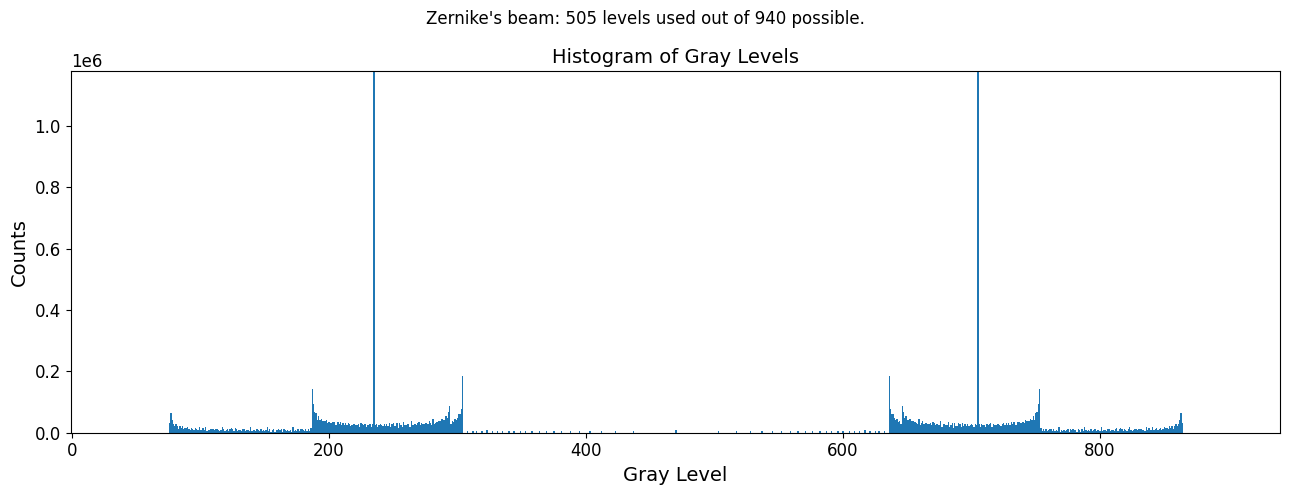

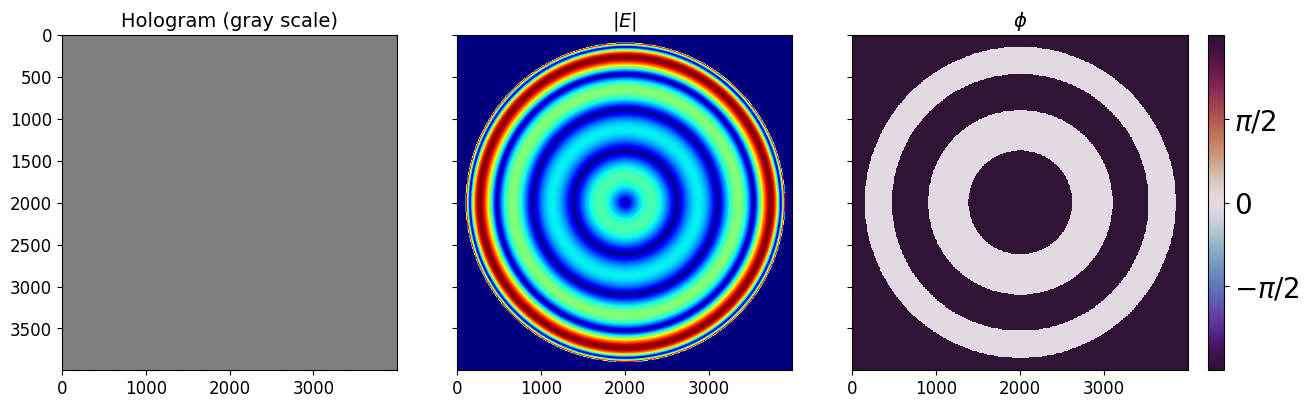

Figure 2: Just a check after holo generation (should be similar/equal to the theoretical one, but doubled in size)


<Figure size 640x480 with 0 Axes>

In [8]:
holo, field = get_holo(profile_EP, phase_levels)

check_holo(holo, phase_levels, label="Zernike's beam", only_hist=True)

fig_num = plot_field(field, title="Just a check after holo generation "
                                  "(should be similar/equal to the theoretical one,"
                                  " but doubled in size)", 
                     holo=holo, fig_num=fig_num)

In [9]:
save_holo(f"Zernike_AmpOnly_{MO_diameter/mm:.0f}mm")

Holo type is: uint16


As can be seen above, not all possibles values of the DOE are used, because we want only to modulate the amplitude (positive and negative). To do that with Arizon's procedure not all values are needed.

Let's add a spiral phase to this amplitude-only beam in order to cover all values.

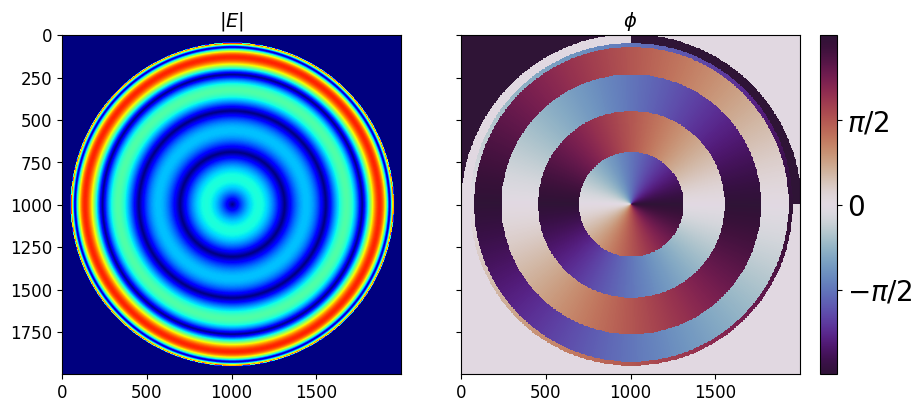

Figure 3: Zernike's beam with spiral phase. (Theoretical one II)
Zernike-Spiral: 940 levels used out of 940 possible.


<Figure size 640x480 with 0 Axes>

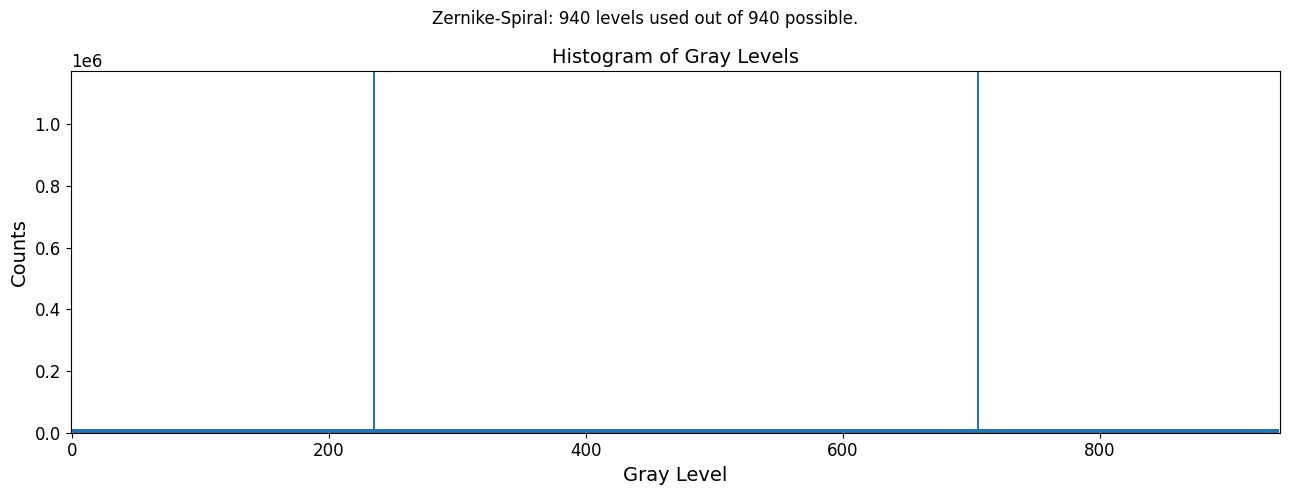

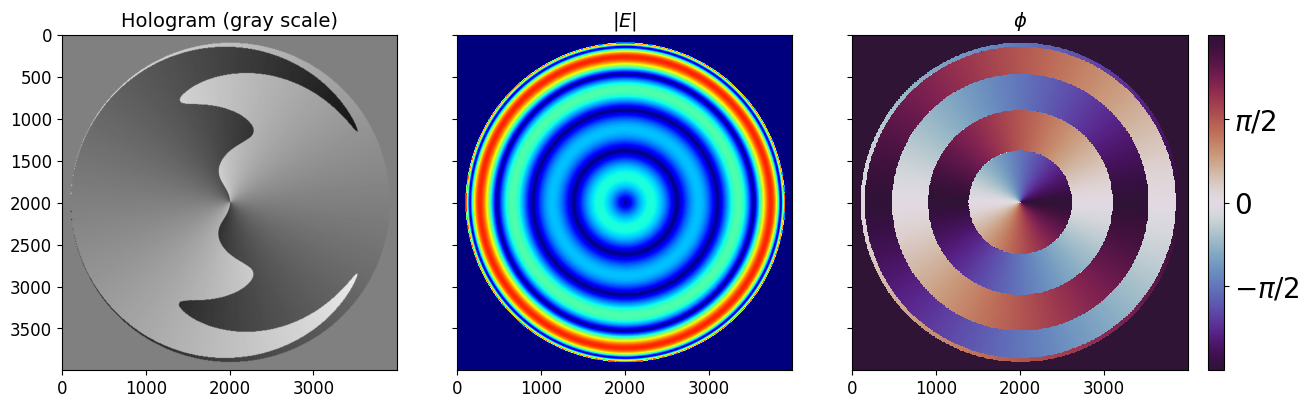

Figure 4: Just a check after holo generation (should be similar/equal to the theoretical II, but doubled in size)


<Figure size 640x480 with 0 Axes>

In [10]:
x, y = np.meshgrid(np.linspace(-1,1, NP), np.linspace(-1,1, NP))
phi = np.atan2(-y, x)

profile_vortex = profile_EP * np.exp(1j*phi)

fig_num = plot_field(profile_vortex, title="Zernike's beam with spiral phase. (Theoretical one II)", fig_num=fig_num)

holo2, field2 = get_holo(profile_vortex, phase_levels)

check_holo(holo2, phase_levels, label="Zernike-Spiral", only_hist=True)
fig_num = plot_field(field2, title="Just a check after holo generation "
                                   "(should be similar/equal to the theoretical II,"
                                   " but doubled in size)", 
                     fig_num=fig_num, holo=holo2)

In [11]:
save_holo(f"Zernike_FullComplex_{MO_diameter/mm:.0f}mm")

Holo type is: uint16


### DOE of same diameter of AOD size

The second attempt is just to set the DOE's diameter equals to the DOE's window's size: `beam_diameter`$=14\,mm$

Efficiency =  0.21381948254868435


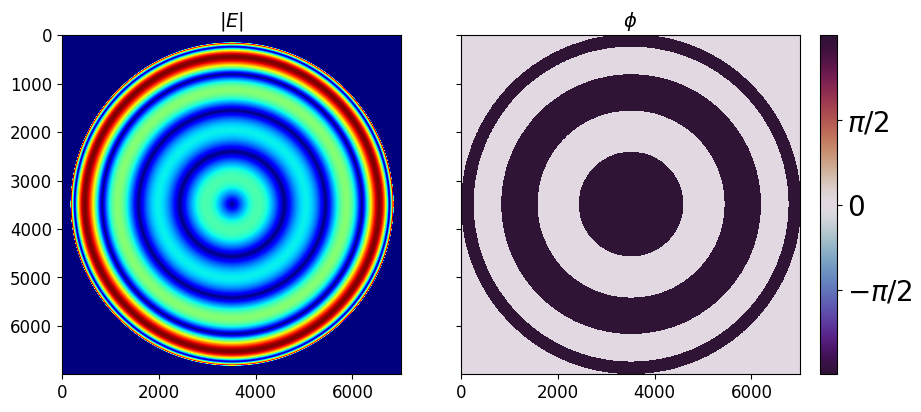

Figure 5: Zernike's beam (theoretical one-big)


<Figure size 640x480 with 0 Axes>

In [12]:
AOD_diameter = 14 * mm

NP2 = int(AOD_diameter/pixel_pitch) // 2  # It's half to consider Arrizon's procedure
rho2 = np.linspace(1e-10,1-1e-10, NP2) # radial variable @ Gaussian sphere of reference

profile_EP2 = ZernikeBeam.get_EP(coeff, NP2, rho2)
fig_num = plot_field(profile_EP2, title="Zernike's beam (theoretical one-big)", fig_num=fig_num)

Zernike's beam: 505 levels used out of 940 possible.


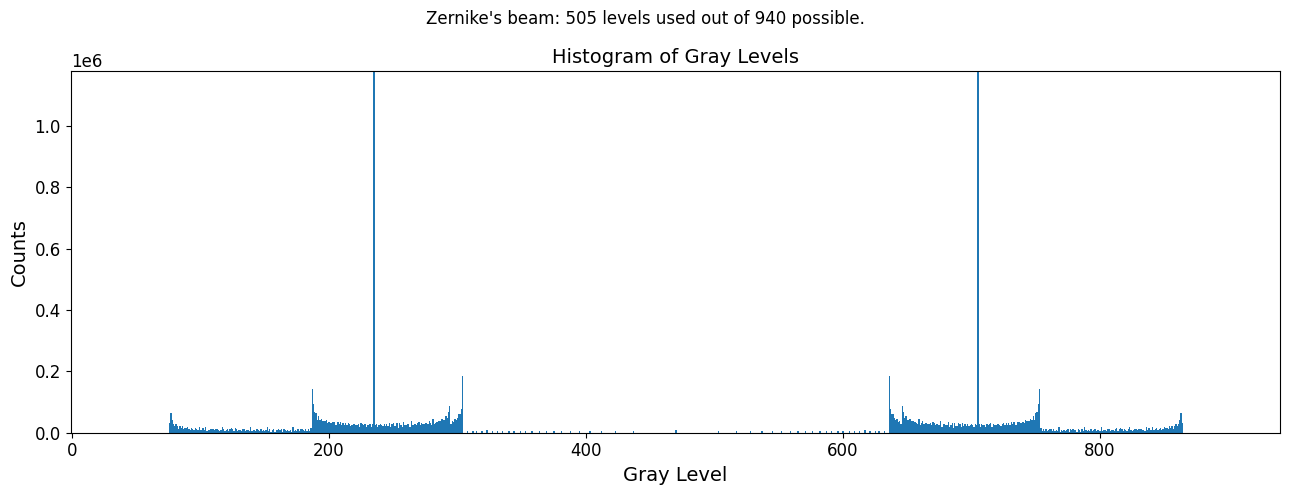

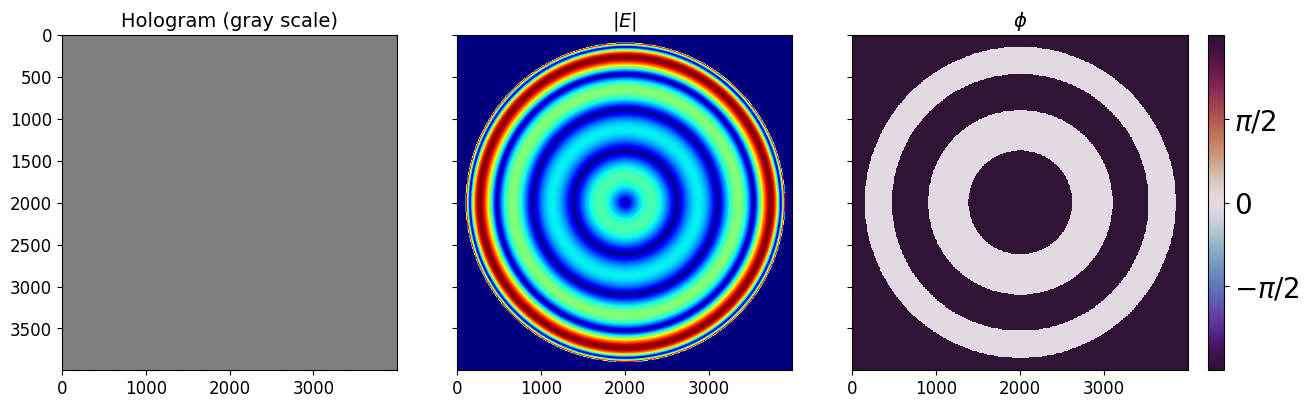

Figure 6: Just a check after holo generation (should be similar/equal to the theoretical one, but doubled in size)
Holo type is: uint16


<Figure size 640x480 with 0 Axes>

In [13]:
holo, field = get_holo(profile_EP, phase_levels)

check_holo(holo, phase_levels, label="Zernike's beam", only_hist=True)

fig_num = plot_field(field, title="Just a check after holo generation "
                                  "(should be similar/equal to the theoretical one,"
                                  " but doubled in size)", 
                     holo=holo, fig_num=fig_num)
save_holo(f"Zernike_AmpOnly_{AOD_diameter/mm:.0f}mm")

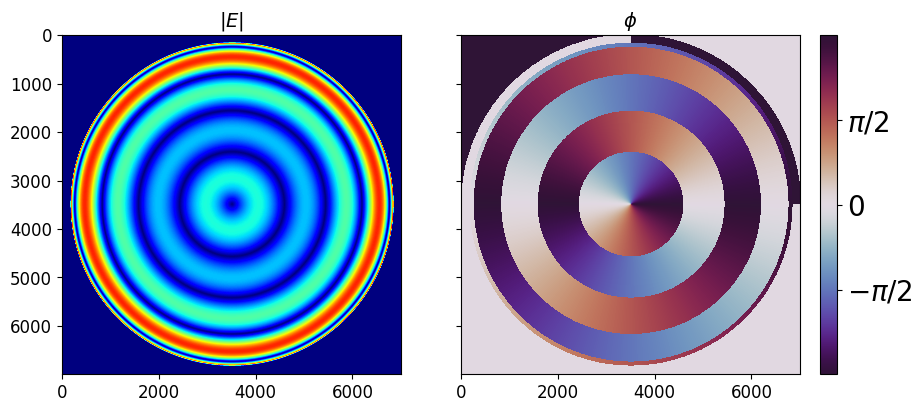

Figure 7: Zernike's beam with spiral phase. (Theoretical one II big)
Zernike-Spiral: 940 levels used out of 940 possible.


<Figure size 640x480 with 0 Axes>

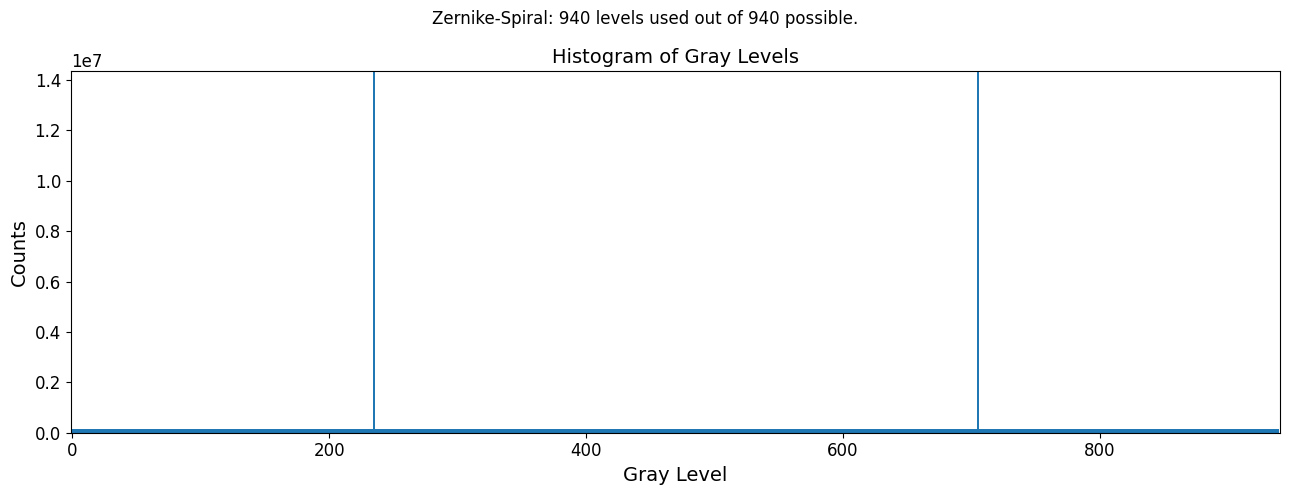

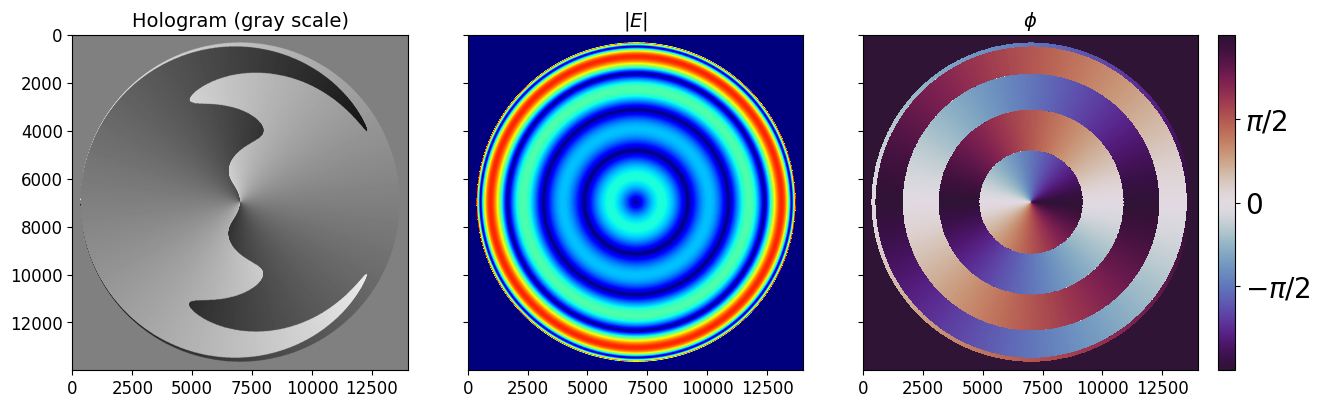

Figure 8: Just a check after holo generation (should be similar/equal to the theoretical II, but doubled in size)
Holo type is: uint16


<Figure size 640x480 with 0 Axes>

In [14]:
x, y = np.meshgrid(np.linspace(-1,1, NP2), np.linspace(-1,1, NP2))
phi = np.atan2(-y, x)

profile_vortex2 = profile_EP2 * np.exp(1j*phi)

fig_num = plot_field(profile_vortex2, title="Zernike's beam with spiral phase. (Theoretical one II big)", fig_num=fig_num)

holo4, field4 = get_holo(profile_vortex2, phase_levels)

check_holo(holo4, phase_levels, label="Zernike-Spiral", only_hist=True)
fig_num = plot_field(field4, title="Just a check after holo generation "
                                   "(should be similar/equal to the theoretical II,"
                                   " but doubled in size)", 
                     fig_num=fig_num, holo=holo4)
save_holo(f"Zernike_FullComplex_{AOD_diameter/mm:.0f}mm")